In [2]:
import pandas as pd
import matplotlib.pyplot as plt


url = "https://breathecode.herokuapp.com/asset/internal-link?id=2545&path=sales.csv"
df = pd.read_csv(url)


print(df.head())
print(df.info())

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)





                         date      sales
0  2022-09-03 17:10:08.079328  55.292157
1  2022-09-04 17:10:08.079328  53.803211
2  2022-09-05 17:10:08.079328  58.141693
3  2022-09-06 17:10:08.079328  64.530899
4  2022-09-07 17:10:08.079328  66.013633
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


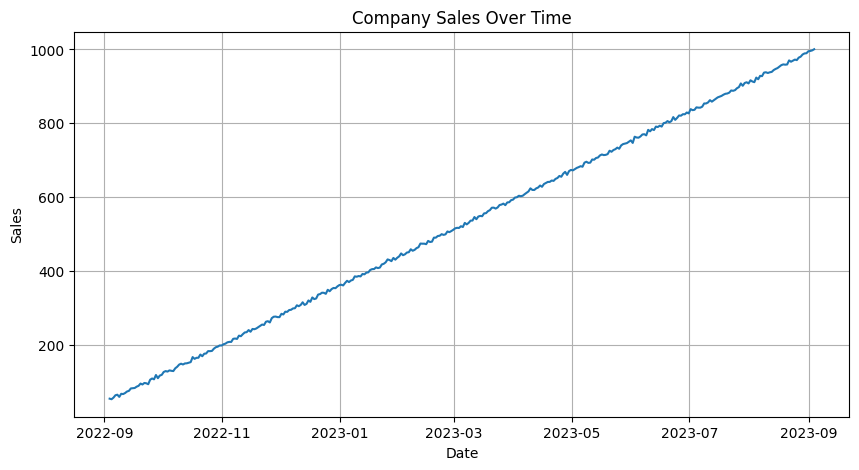

In [6]:
plt.figure(figsize=(10,5))
plt.plot(df['sales'])
plt.title('Company Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
%matplotlib inline
plt.show()

In [7]:

# Identify the tensor (time unit)
print(df.index.to_series().diff().value_counts())


from statsmodels.tsa.stattools import adfuller

result = adfuller(df['sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
# p < 0.05 → stationary, p > 0.05 → not stationary

# Observe variability / noise on the chart


date
1 days    365
Name: count, dtype: int64
ADF Statistic: 0.5454141937063742
p-value: 0.9861899815311063


Searching for best ARIMA order...


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was 

✅ Best ARIMA order: (1, 2, 2) with AIC=1482.399038636916

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  292
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -737.200
Date:                Sat, 08 Nov 2025   AIC                           1482.399
Time:                        00:50:44   BIC                           1497.079
Sample:                    09-03-2022   HQIC                          1488.280
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0862      0.059     -1.460      0.144      -0.202       0.030
ma.L1         -1.9203      0.934     -2.055      0.040    

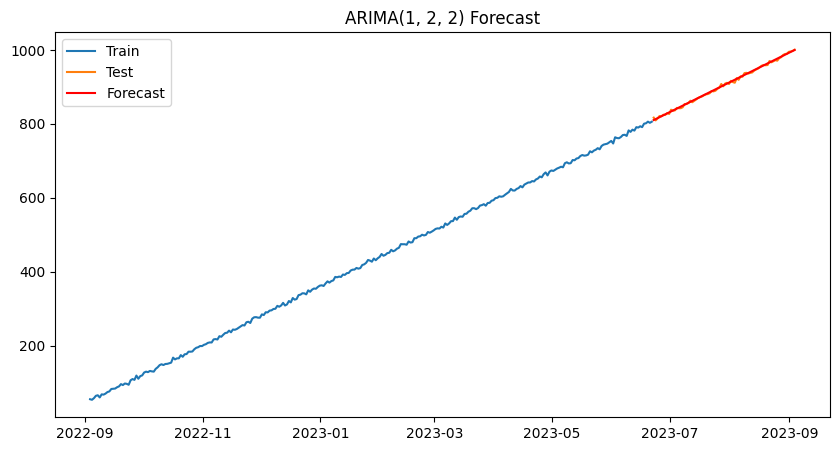

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("sales.csv", parse_dates=['date'], index_col='date')

# Split into training and test (e.g., last 20% for testing)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Define p, d, q ranges for ARIMA
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Initialize best model tracking
best_aic, best_order = float("inf"), None

print("Searching for best ARIMA order...")

# Grid search for best (p,d,q)
for order in pdq:
    try:
        model = ARIMA(train['sales'], order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
    except:
        continue

print(f"✅ Best ARIMA order: {best_order} with AIC={best_aic}")

# Train final ARIMA model using best order
final_model = ARIMA(train['sales'], order=best_order)
final_result = final_model.fit()

print("\nModel Summary:")
print(final_result.summary())

# Forecast on test data
forecast = final_result.forecast(steps=len(test))

# Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(train.index, train['sales'], label='Train')
plt.plot(test.index, test['sales'], label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title(f'ARIMA{best_order} Forecast')
plt.legend()
%matplotlib inline
plt.show()


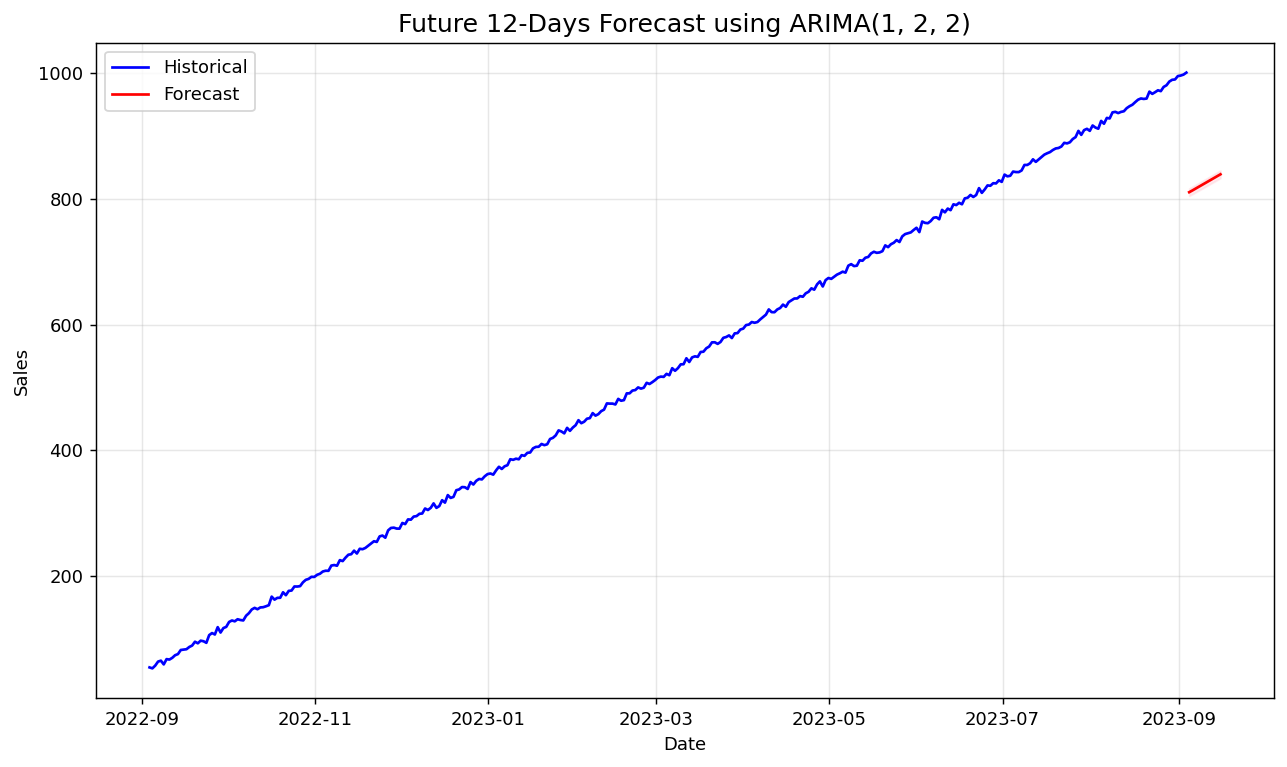

In [ ]:
# ==============================================
# 🔹 Seamless, Auto-Labeled ARIMA Forecast Plot
# ==============================================

import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime index
df.index = pd.to_datetime(df.index)

# Try to infer the frequency of the time series
freq = pd.infer_freq(df.index)

# Fallback if frequency can't be detected
if freq is None:
    # Check rough spacing between points
    avg_gap = (df.index[1:] - df.index[:-1]).median().days
    if avg_gap > 20:
        freq = 'M'
    else:
        freq = 'D'
    df = df.asfreq(freq)

# Forecast next 12 periods
n_steps = 12
forecast_result = final_result.get_forecast(steps=n_steps)
forecast_mean = forecast_result.predicted_mean
forecast_conf = forecast_result.conf_int()

# Create continuous index that starts immediately after last observation
future_index = pd.date_range(
    start=df.index[-1] + pd.tseries.frequencies.to_offset(freq),
    periods=n_steps,
    freq=freq
)
forecast_series = pd.Series(forecast_mean.values, index=future_index)

# Determine label for chart title
time_unit = "Months" if "M" in freq else "Days"

# =====================
# Plot
# =====================
plt.figure(figsize=(10,6), dpi=130)

plt.plot(df.index, df['sales'], label='Historical', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')

# Add confidence interval shading
plt.fill_between(
    forecast_series.index,
    forecast_conf.iloc[:, 0],
    forecast_conf.iloc[:, 1],
    color='pink', alpha=0.3
)

plt.title(f"Future 12-{time_unit} Forecast using ARIMA{best_order}", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
%matplotlib inline
plt.show()




In [18]:
# ==============================================
# 🔹 Export Forecast Results to CSV
# ==============================================

# Combine the forecast data and confidence intervals into one DataFrame
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean.values,
    'Lower CI': forecast_conf.iloc[:, 0].values,
    'Upper CI': forecast_conf.iloc[:, 1].values
}, index=future_index)

# Save to CSV
forecast_df.to_csv('sales_forecast.csv', index_label='Date')

print("✅ Forecast results saved to 'sales_forecast.csv'")
print(forecast_df.head())


✅ Forecast results saved to 'sales_forecast.csv'
                              Forecast    Lower CI    Upper CI
2023-09-04 17:10:08.079328  810.472581  804.568884  816.376279
2023-09-05 17:10:08.079328  812.904763  807.001078  818.808448
2023-09-06 17:10:08.079328  815.516849  809.592552  821.441147
2023-09-07 17:10:08.079328  818.113422  812.171969  824.054875
2023-09-08 17:10:08.079328  820.711333  814.752367  826.670298


In [20]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the model again with your chosen order
model = ARIMA(train['sales'], order=best_order)
model_fit = model.fit()

# Then save it
import joblib, os
os.makedirs("models", exist_ok=True)
joblib.dump(model_fit, "models/arima_sales_model.pkl")
print("✅ Model saved as models/arima_sales_model.pkl")


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


✅ Model saved as models/arima_sales_model.pkl
